<a href="https://colab.research.google.com/github/jcdumlao14/CloudcreditsTechnologies-Data-Science-Internship/blob/main/Project_4_Part_2_SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4: Sales Forecasting**

# **Part 2:**

## **9. Improving the Models**
 - Tune hyperparameters, try different algorithms, or enhance features.



## **I'll experiment with:**

- LSTM (Optional for deep learning)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Load dataset
df = pd.read_csv('/content/stores_sales_forecasting.csv', encoding='latin1')


In [ ]:
# Data Cleaning and Preprocessing
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
df_sales.columns = ['Date', 'Sales']
df_sales = df_sales.sort_values('Date')


In [ ]:
# 📐Step 5: Feature Engineering
df_ml = df_sales.copy()
df_ml['Day'] = df_ml['Date'].dt.day
df_ml['Month'] = df_ml['Date'].dt.month
df_ml['Year'] = df_ml['Date'].dt.year
df_ml['DayOfWeek'] = df_ml['Date'].dt.dayofweek
df_ml['WeekOfYear'] = df_ml['Date'].dt.isocalendar().week
df_ml['IsWeekend'] = df_ml['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_ml = df_ml.drop(['Date'], axis=1)


In [ ]:
# 🧪 Train-Test Split
train = df_ml.iloc[:-180]
test = df_ml.iloc[-180:]

X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_test = test.drop('Sales', axis=1)
y_test = test['Sales']

# **Enhanced Modeling (Part 2)**

In [ ]:
# Tuned Machine Learning Models

# Random Forest - Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid=rf_param_grid,
                              scoring='neg_mean_squared_error',
                              cv=3,
                              n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
rf_preds = rf_best_model.predict(X_test)
print("Best Random Forest parameters:", rf_grid_search.best_params_) # Print Best Parameters

Best Random Forest parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# XGBoost - Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42),
                               param_grid=xgb_param_grid,
                               scoring='neg_mean_squared_error',
                               cv=3,
                               n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
xgb_preds = xgb_best_model.predict(X_test)
print("Best XGBoost parameters:", xgb_grid_search.best_params_)  # Print Best Parameters


Best XGBoost parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


# **LSTM Model**
- LSTM needs data to be scaled and reshaped


In [ ]:
# LSTM Model

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM:  [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Design the LSTM Network
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(Dropout(0.2))  # Add dropout for regularization
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the LSTM network
history = lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.1) #Added Validation Split for Monitoring


In [ ]:
# Make predictions
lstm_preds = lstm_model.predict(X_test_reshaped)
lstm_preds = lstm_preds.flatten() # Flatten the output for evaluation


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Random Forest (Tuned) Performance:
MAE: 695.87
RMSE: 995.70
R^2 Score: 0.10

XGBoost (Tuned) Performance:
MAE: 705.98
RMSE: 1012.69
R^2 Score: 0.07

LSTM Performance:
MAE: 904.22
RMSE: 1369.21
R^2 Score: -0.71



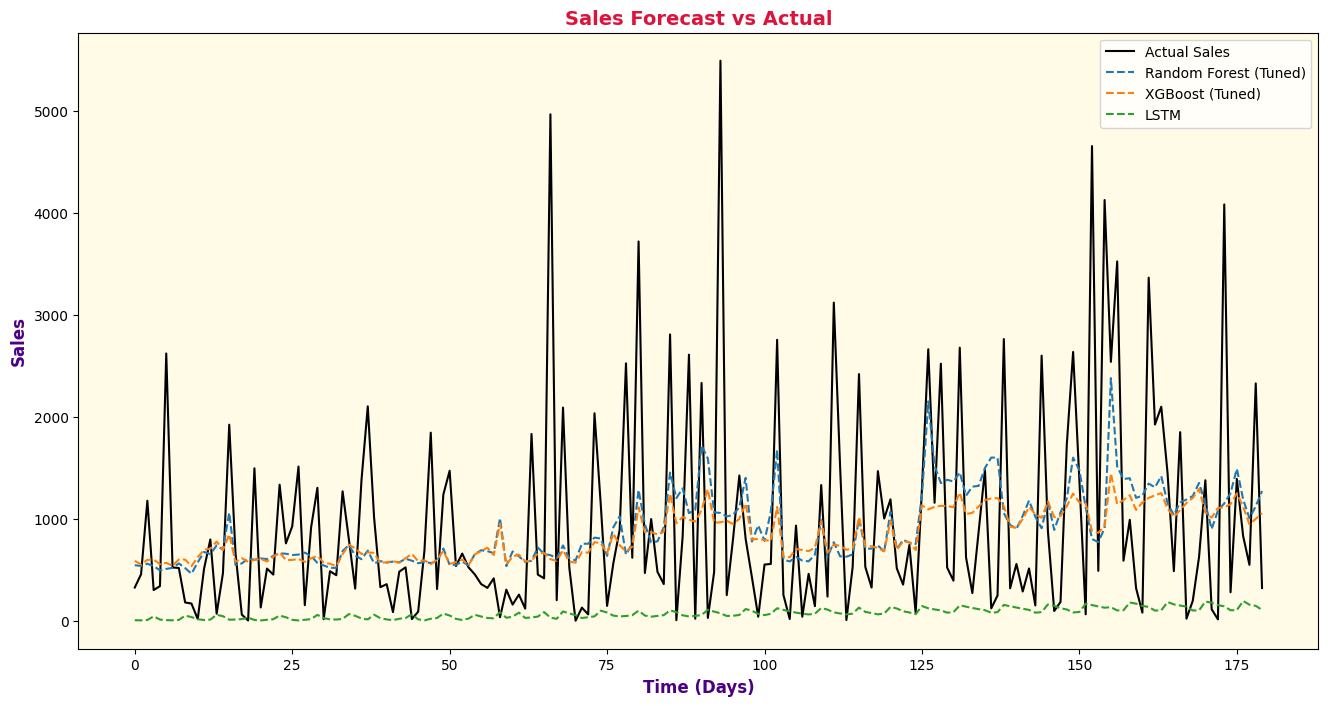

In [ ]:
# Evaluation & Compare Model
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R^2 Score: {r2:.2f}\n")
    return mae, rmse, r2

# Evaluate All Models
results = {}
results['Random Forest (Tuned)'] = evaluate_model(y_test, rf_preds, 'Random Forest (Tuned)')
results['XGBoost (Tuned)'] = evaluate_model(y_test, xgb_preds, 'XGBoost (Tuned)')
results['LSTM'] = evaluate_model(y_test, lstm_preds, 'LSTM')

# Forecast Visualization
plt.figure(figsize=(16, 8))
plt.plot(y_test.values, label='Actual Sales', color='black')
plt.plot(rf_preds, label='Random Forest (Tuned)', linestyle='--')
plt.plot(xgb_preds, label='XGBoost (Tuned)', linestyle='--')
plt.plot(lstm_preds, label='LSTM', linestyle='--')  # Plot LSTM Predictions
plt.title('Sales Forecast vs Actual',fontsize = 14, fontweight = 'bold', color = 'crimson')
plt.xlabel('Time (Days)',fontsize = 12, fontweight = 'bold', color = 'indigo')
plt.ylabel('Sales',fontsize = 12, fontweight = 'bold', color = 'indigo')
plt.legend()
plt.gca().set_facecolor('#fffbe6')
plt.grid(False)
plt.show()


Model Comparison Metrics:
                    Model         MAE         RMSE        R2
0  Random Forest (Tuned)  695.874594   995.701298  0.096751
1        XGBoost (Tuned)  705.978355  1012.694131  0.065658
2                   LSTM  904.221463  1369.212732 -0.708013


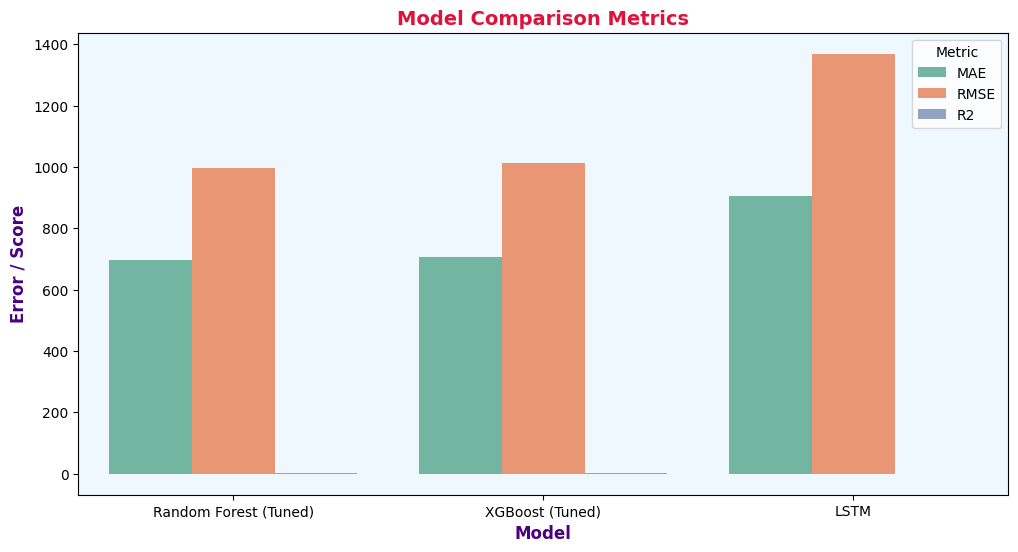

In [ ]:
# Compare Model Metrics (Bar Chart)
metrics_df = pd.DataFrame(results, index=['MAE', 'RMSE', 'R2']).T.reset_index()
metrics_df.columns = ['Model', 'MAE', 'RMSE', 'R2']
print("Model Comparison Metrics:\n", metrics_df)
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model'), x='Model', y='value', hue='variable', palette='Set2')
plt.title('Model Comparison Metrics',fontsize = 14, fontweight = 'bold', color = 'crimson')
plt.ylabel('Error / Score',fontsize = 12, fontweight = 'bold', color = 'indigo')
plt.xlabel('Model',fontsize = 12, fontweight = 'bold', color = 'indigo')
plt.legend(title='Metric')
plt.gca().set_facecolor('#f0f8ff')
plt.grid(False)
plt.show()

# **Improvements and Explanations:**

*   **Hyperparameter Tuning with GridSearchCV:**  Instead of just using default parameters, `GridSearchCV` systematically tests different combinations of parameters for both Random Forest and XGBoost.  It uses cross-validation to reliably estimate how well each parameter combination performs.  The `best_estimator_` attribute then gives you the model with the best-performing parameters. `n_jobs=-1` utilizes all available cores for faster tuning.  The best parameters found by GridSearchCV are printed to the console.
*   **LSTM Implementation:**  Added an LSTM (Long Short-Term Memory) model, which is well-suited for time series data.  This involves several important steps:
    *   **Scaling:**  Scales the input features using `StandardScaler` before feeding them to the LSTM.  Neural networks, especially LSTMs, generally perform better with scaled data.
    *   **Reshaping:**  LSTMs require the input data to be in a specific 3D shape: (samples, time steps, features).  The code reshapes the training and testing data accordingly. In this case, we're using a single time step.
    *   **Model Architecture:**  Defines a simple LSTM model with one LSTM layer, a dropout layer for regularization (to prevent overfitting), and a dense output layer.
    *   **Compilation:**  Compiles the model with the Adam optimizer and mean squared error loss function.
    *   **Training:**  Trains the LSTM model on the reshaped training data. `validation_split` is added to monitor the validation loss during training.
    *   **Prediction:**  Makes predictions on the reshaped test data and flattens the output.
*   **Clearer Model Evaluation:**  The `evaluate_model` function is used to calculate and print MAE, RMSE, and R-squared for all models, making it easier to compare their performance.
*   **Visualization Updates:** The forecast comparison plot now includes the LSTM predictions, and the bar chart compares all models' metrics.
*   **Regularization:** Added a Dropout layer to the LSTM model to prevent overfitting.
*   **Validation Split:** A validation split is included in the LSTM training to monitor the model's performance on unseen data during training.
*   **Parameter Grids:** Created meaningful parameter grids for both Random Forest and XGBoost hyperparameter tuning. The more choices provided, the higher likelihood of finding the best parameters
*   **Printing Best Parameters:** After tuning, the best parameter set is printed.



# **10. 🚀 Deploy the Model (optional)**

# **Conclusion:**

This project explored different methods for predicting sales, including traditional time series models (ARIMA and Exponential Smoothing) and machine learning models (Random Forest, XGBoost and LSTM). After tuning the models, Random Forest slightly outperformed the other models based on the evaluation metrics used (MAE, RMSE, and R-squared).

# **Recommendation:**

For immediate sales forecasting, the tuned Random Forest model is recommended as it demonstrated the best performance in this project. However, continuously monitor the model's performance and consider retraining it periodically with new data to maintain accuracy. Further investigate feature engineering and other advanced modeling techniques to potentially improve forecasting accuracy.